Created on 4/2/2020
Author: Yuan-Chi Yang

Objective: template for content analysis on political feedback, please feel free to modify and play around

In [1]:
import pandas as pd
import nltk
import re

# Importing the data and perform some checks

The data is from "C:\Users\yyang60\PostDoct-Emory\medicaid-project\medicaid-classifier\labeling-data\whole_dataset\BERT_20200228\political-tweets-streaming.csv"

It consists of all the tweets classified as the 'p' class by the best performing classfiers to date.

In [2]:
df = pd.read_csv('./political-tweets-streaming.csv',header = 0, keep_default_na=False,dtype={'tweet_id':str})

In [25]:
len(df)

383969

In [3]:
df.columns

Index(['tweet_id', 'user_id', 'unprocessed_text', 'time', 'class'], dtype='object')

### Check Duplicates
No Duplicated

In [4]:
df.duplicated(subset = ['tweet_id'], keep=False).sum()

0

### Include 'text_remove_stopwords' column

In [6]:
def loadStopWords(FILENAME):
    stopword_list = []
    infile = open(FILENAME)
    for line in infile:
        stopword_list.append(line.strip())
    print(len(stopword_list))
    return stopword_list

In [7]:
def processing_text_remove_stopwords(tweet_text,stop_words):
    tweet_text = re.sub(r'&amp;', "and", tweet_text)
    tweet_text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '',
                        tweet_text)
    #tweet_text = re.sub('(@[A-Za-z0-9\_]+)', '', tweet_text)
    tweet_text = re.sub('(@[\S]+)', '', tweet_text)#added Angel
    ####the following section separate words following each hashtag
    list_hashtag1=re.findall('(#[\S]+)',tweet_text)
    list_hashtag2=[]
    for p in list_hashtag1:
        p=re.sub('(#)',' ',p)#clear hashtag symbols
        p1=re.findall('([A-Z]{2,})',p)#uppercase abbrevs
        for p2 in p1:
            list_hashtag2.append(p2)#add abbrevs
        p=re.sub('([A-Z]{2,})',' ',p)#clear uppercase abbrevs
        p1=re.findall('([A-Z][a-z]{1,})',p)#words start uppercase letter
        for p2 in p1:
            list_hashtag2.append(p2)
        p=re.sub('([A-Z][a-z]{1,})',' ',p)#clear words start with uppercase letter
        p=re.sub('([A-Z])',' ',p)#clear single uppercase letters
        p=re.sub('([^A-Za-z])',' ',p)#clear symbols
        p1=p.split()#find leftover words
        for p2 in p1:
            list_hashtag2.append(p2)#add leftover words
    tweet_text=re.sub('(#[\S]+)','',tweet_text)
    
    tweet_text = re.sub("[^a-zA-Z_-]", " ", tweet_text)
    tweet_text = tweet_text.lower()
    tweet_text = re.sub(r'\s{2,}', " ", tweet_text)
    list_hashtag= [h for h in list_hashtag2 if (not h in stop_words and len(h)>1)]
    tweet_text = [t for t in tweet_text.split() if (not t in stop_words and len(t)>1)]
    tweet_text.extend(list_hashtag)
    return ' '.join(tweet_text)

In [8]:
stopwords = set(loadStopWords('./stopwords.txt'))

261


In [10]:
df['text_remove_stopwords'] = df['unprocessed_text'].apply(lambda x: processing_text_remove_stopwords(x,stopwords))

## Find the most frequent words in text

In [11]:
unigrams = ' '.join(df['text_remove_stopwords'].to_list()).split()
bigrams = []
for tweet in df['text_remove_stopwords'].to_list():
    bigrams += list(nltk.bigrams(tweet.split()))
    
trigrams = []
for tweet in df['text_remove_stopwords'].to_list():
    trigrams += list(nltk.trigrams(tweet.split()))
uni_fd = nltk.FreqDist(unigrams)
big_fd = nltk.FreqDist(bigrams)
trig_fd = nltk.FreqDist(trigrams)


In [ ]:
def wordInNumTweets(s):
    pattern = rf'(^|[^a-zA-Z]){s}([^a-zA-Z]|$)' #rf is for using a variable inside
    count=0
    for i in range(len(df['text_remove_stopwords'])):
         if re.search(pattern,df['text_remove_stopwords'].iloc[i]) is not None :
            count=count+1
    return count

In [ ]:
num = 40

print('unigrams:\n')
fd = uni_fd
fd_list = [(x,fd[x]) for x in fd]
fd_list.sort(key = lambda x: x[1], reverse = True)
df_term1=[]
df_count1=[]
df_numtweets1=[]
for i in range(0,num):
    print(fd_list[i][0], fd_list[i][1])
    df_term1.append(fd_list[i][0])
    df_count1.append(fd_list[i][1])
    df_numtweets1.append(wordInNumTweets(fd_list[i][0]))

print('--------------------------------------------------------\n')
print('bigrams:\n')
fd = big_fd
fd_list = [(x,fd[x]) for x in fd]
fd_list.sort(key = lambda x: x[1], reverse = True)
df_term2=[]
df_count2=[]
df_numtweets2=[]
for i in range(0,num):
    x, y= fd_list[i][0]
    term = x + ' '+ y
    print(term, fd_list[i][1])
    df_term2.append(term)
    df_count2.append(fd_list[i][1])
    df_numtweets2.append(wordInNumTweets(term))

print('--------------------------------------------------------\n')
print('trigrams:\n')
fd = trig_fd
fd_list = [(x,fd[x]) for x in fd]
fd_list.sort(key = lambda x: x[1], reverse = True)
df_term3=[]
df_count3=[]
df_numtweets3=[]
for i in range(0,num):
    x, y, z= fd_list[i][0]
    term = x + ' '+ y + ' ' + z
    print(term, fd_list[i][1])
    df_term3.append(term)
    df_count3.append(fd_list[i][1])
    df_numtweets3.append(wordInNumTweets(term))
df_ubt={'uni_term':df_term1,'uni_count':df_count1,'uni_numtw':df_numtweets1,'bi_term':df_term2,'bi_count':df_count2,'bi_numtw':df_numtweets2,'tri_term':df_term3,'tri_count':df_count3,'tri_numtw':df_numtweets3}
df_ubt=pd.DataFrame(df_ubt)
df_ubt.to_csv('ubt40.csv')

unigrams:

people 66954
social 64162
security 59281
care 51287
get 48687
health 41356
would 40135
pay 39945
insurance 39921
trump 39077
healthcare 38641
expansion 38198
like 35822
cut 30612
tax 29473
state 29422
cuts 28059
need 26424
want 26282
food 23709
work 23698
programs 23589
us 23326
re 23125
money 22908
states 21239
aca 20763
free 20572
one 19826
know 19507
also 19277
take 19129
government 19113
poor 19012
public 18829
many 18774
stamps 18513
budget 18252
coverage 17871
make 17382
--------------------------------------------------------

bigrams:

social security 56343
food stamps 18233
health care 16441
health insurance 8651
tax cuts 6999
private insurance 5939
cut social 5701
cuts social 4495
take away 4110
work requirements 3636
middle class 3528
low income 3129
mental health 3037
budget cuts 2976
pre-existing conditions 2964
Medicare Medicaid 2922
trump budget 2918
For All 2791
insurance companies 2751
tax cut 2736
poor people 2705
public schools 2632


## Add sentiment scores to all tweets

In [16]:
print(df['polarity'].iloc[1])

0.2


In [17]:
print(df['polarity'].iloc[111])

0.0


In [18]:
print(df['polarity'].iloc[311])

0.2857142857142857


In [13]:
from textblob import TextBlob
def addpolarityscores(text):
    t=TextBlob(text)
    return t.sentiment.polarity
def addsubjectivityscores(text):
    t=TextBlob(text)
    return t.sentiment.subjectivity

In [15]:
df['polarity'] = df['text_remove_stopwords'].apply(lambda x:addpolarityscores(x))
df['subjectivity'] = df['text_remove_stopwords'].apply(lambda x:addsubjectivityscores(x))

## Add label of 1/0 based on the existence/absence of each interesting term

In [19]:
def highfreqword(text,terms):
    exist=0
    for j in range(len(terms)):
        pattern = rf'(^|[^a-zA-Z]){terms[j]}([^a-zA-Z]|$)' #rf is for using a variable inside
        if(re.search(pattern,text)!=None):
            return 1
    return 0

In [20]:
term_ls=[['cut social security','cutting social security','cuts social security','social security cuts'],['mental health'],['middle class'],['affordable care act','aca'],['tax cut','tax cuts'],['food stamps'],['low income'],['planned parenthood'],['minimum wage'],['illegal immigrants']]
for i in range(10):
    label_name=(term_ls[i])[0]
    df[label_name] = df['text_remove_stopwords'].apply(lambda x:highfreqword(x,term_ls[i]))


In [55]:
print(df.head(1))

              tweet_id              user_id  \
0  1044312532419317762  1036076125041176576   

                                    unprocessed_text                 time  \
0  @FerrisNed Except everyone on Medicaid in the ...  2018-09-24 19:48:04   

  class                              text_remove_stopwords  polarity  \
0     p  except everyone us already getting treatment d...  0.366667   

   subjectivity  cut social security  mental health  middle class  \
0           0.7                    0              0             0   

   affordable care act  tax cut  food stamps  low income  planned parenthood  \
0                    0        0            0           0                   0   

   minimum wage  illegal immigrants  
0             0                   0  


In [51]:
print(len(df))

383969


In [69]:
subset=df[df['mental health']==1]

-0.010855438091596616


In [92]:
subset=df[df['illegal immigrants']==1]
print(len(df))
print(sum(df['polarity'])/len(df))
#df1['subjectivity'].plot(linewidth=0.5)

383969
0.03787318317618698


Load the dataframe with labels and scores added

In [52]:
import pandas as pd
import nltk
import re
df = pd.read_csv('./df_labels_scores.csv',header = 0, keep_default_na=False,dtype={'tweet_id':str})

In [53]:
subset=df[df['yr_month']=='2018-12']
subset=subset[subset['cut social security']==1]
print(len(subset))
subset.sample(1).to_csv('tmp_cut_social_security2.csv')

KeyError: 'yr_month'

In [87]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter

Polarity Distribution Plots

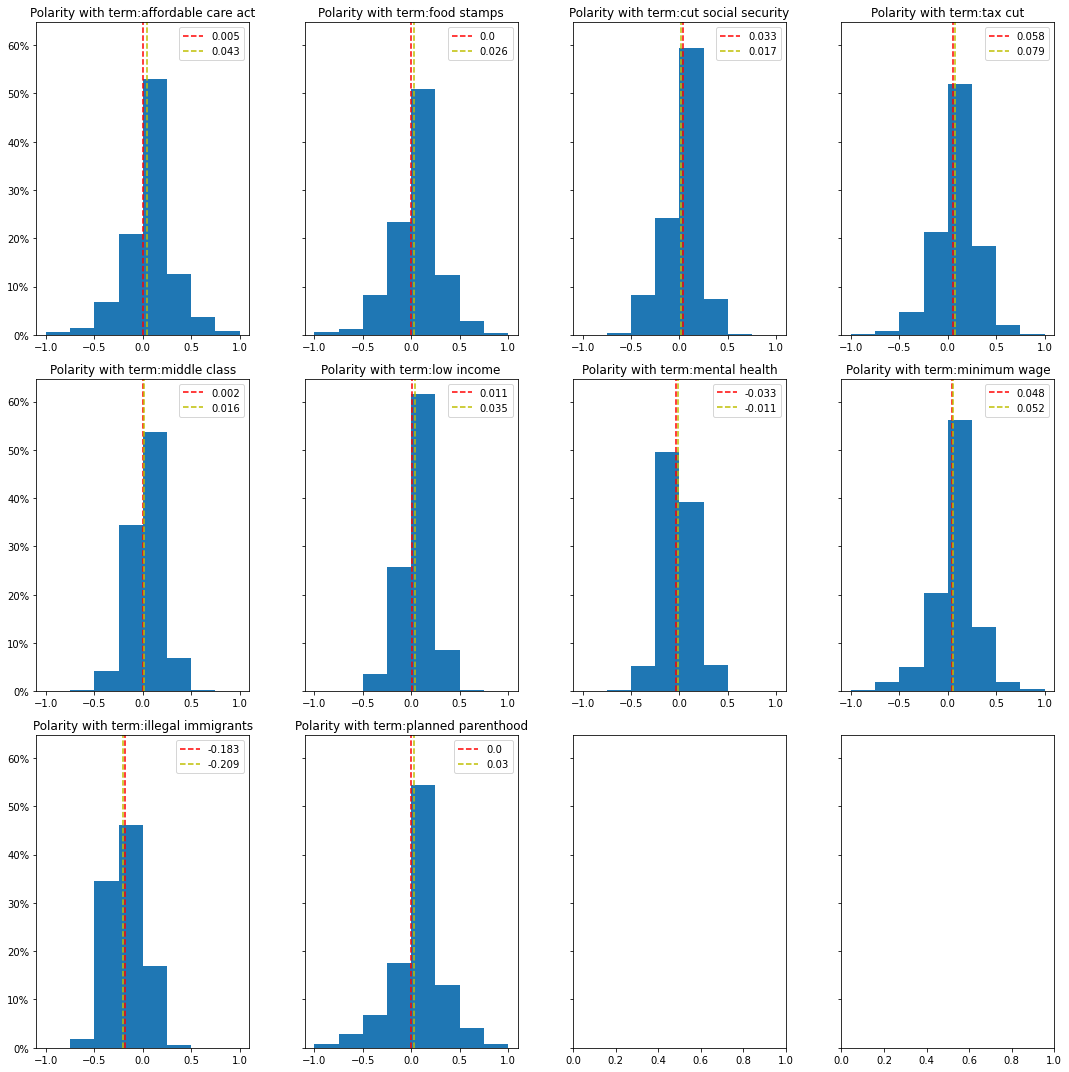

In [135]:
figure,axes=plt.subplots(3,4,tight_layout=True,sharey="all",figsize=(15,15))
titles=['affordable care act','food stamps','cut social security','tax cut','middle class','low income','mental health','minimum wage','illegal immigrants','planned parenthood']
binls=[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]
axes=axes.ravel()
for ax,title in zip(axes,titles):
    subset=df[df[title]==1]
    ax.hist(subset['polarity'],weights=np.ones(len(subset))/len(subset),bins=binls)
    ax.axvline(subset['polarity'].median(),linestyle='dashed',color='r',label="median "+str(round(np.median(subset['polarity']),3)))
    ax.axvline(subset['polarity'].mean(),linestyle='dashed',color='y',label="mean "+str(round(np.mean(subset['polarity']),3)))
    ax.legend(loc='upper right')
    title1='Polarity:'+title
    ax.set_title(title1)
    ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

Subjectivity Distribution Plots

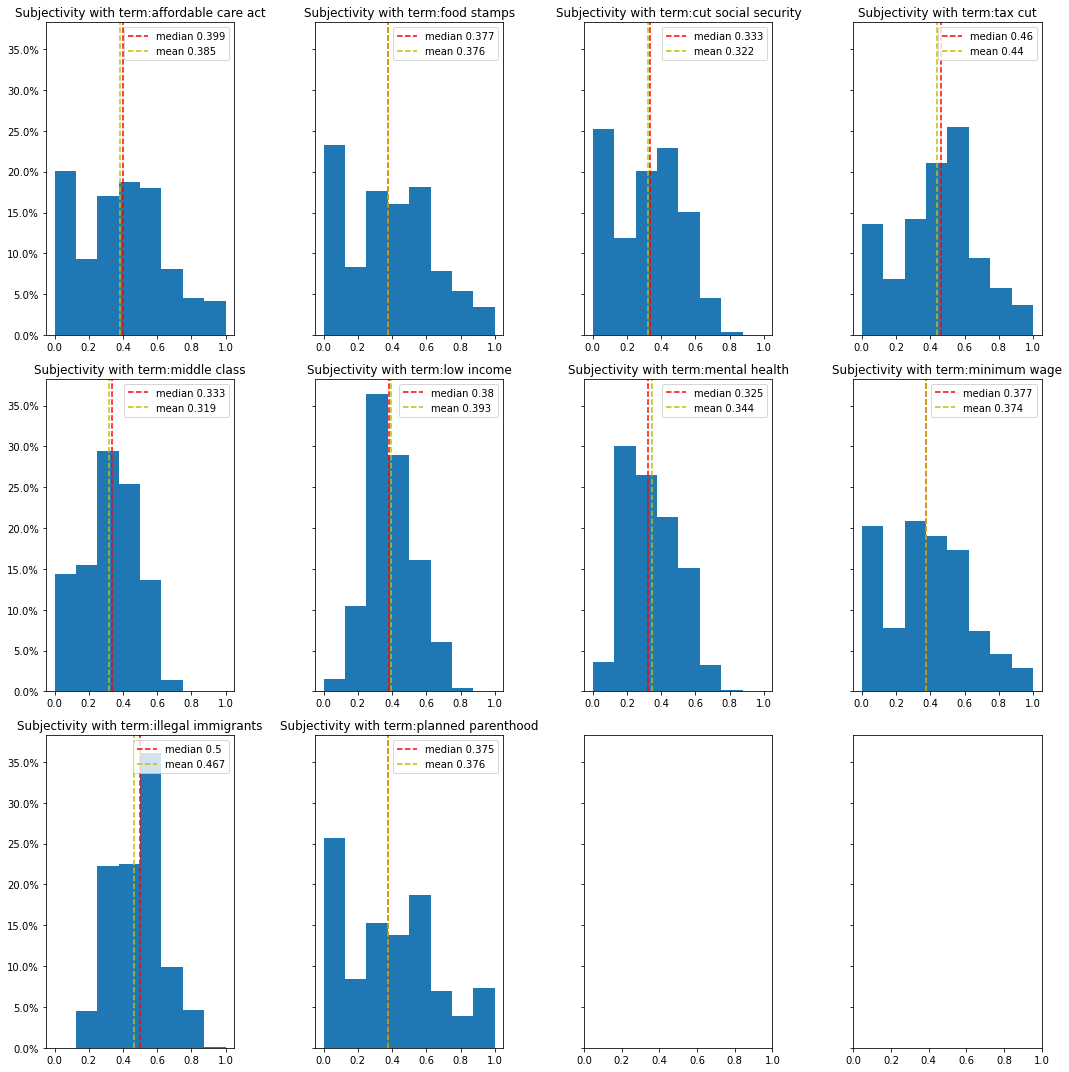

In [136]:
figure,axes=plt.subplots(3,4,tight_layout=True,sharey="all",figsize=(15,15))
titles=['affordable care act','food stamps','cut social security','tax cut','middle class','low income','mental health','minimum wage','illegal immigrants','planned parenthood']
binls=[0,0.125,0.25,0.375,0.5,0.625,0.75,0.875,1]
axes=axes.ravel()
for ax,title in zip(axes,titles):
    subset=df[df[title]==1]
    ax.hist(subset['subjectivity'],weights=np.ones(len(subset))/len(subset),bins=binls)
    ax.axvline(subset['subjectivity'].median(),linestyle='dashed',color='r',label="median "+str(round(np.median(subset['subjectivity']),3)))
    ax.axvline(subset['subjectivity'].mean(),linestyle='dashed',color='y',label="mean "+str(round(np.mean(subset['subjectivity']),3)))
    ax.legend(loc='upper right')
    title1='Subjectivity:'+title
    ax.set_title(title1)
    ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

Table with Standard Deviation and Number of Occurrences

In [151]:
df['yr_month'] = df['time'].apply(lambda x:x[:7])

In [157]:
import numpy as np
titles=['affordable care act','food stamps','cut social security','tax cut','middle class','low income','mental health','minimum wage','illegal immigrants','planned parenthood']
terms=[]
times=[]
occs=[]
pol_means=[]
subj_means=[]
pol_err=[]
subj_err=[]
for title in titles:
    df1=df[df[title]==1]
    x1=list(df1.groupby(['yr_month']).groups.keys())
    for xx1 in x1:
        terms.append(title)
        times.append(xx1)
        subset=df1[df1['yr_month']==xx1]
        subj_err.append(np.std(subset['subjectivity']))
        subj_means.append((subset['subjectivity']).mean())
        pol_err.append(np.std(subset['polarity']))
        pol_means.append((subset['polarity']).mean())
        occs.append(len(subset))
table={'term':terms,'yr_month':times,'num_of_occurrences':occs,'polarity_mean':pol_means,'polarity_st_dev':pol_err,'subjectivity_mean':subj_means,'subjectivity_st_dev':subj_err}
table=pd.DataFrame(table)
table.to_csv('times_series_table.csv')


Time Series plots of Polarity Trend with Errbar

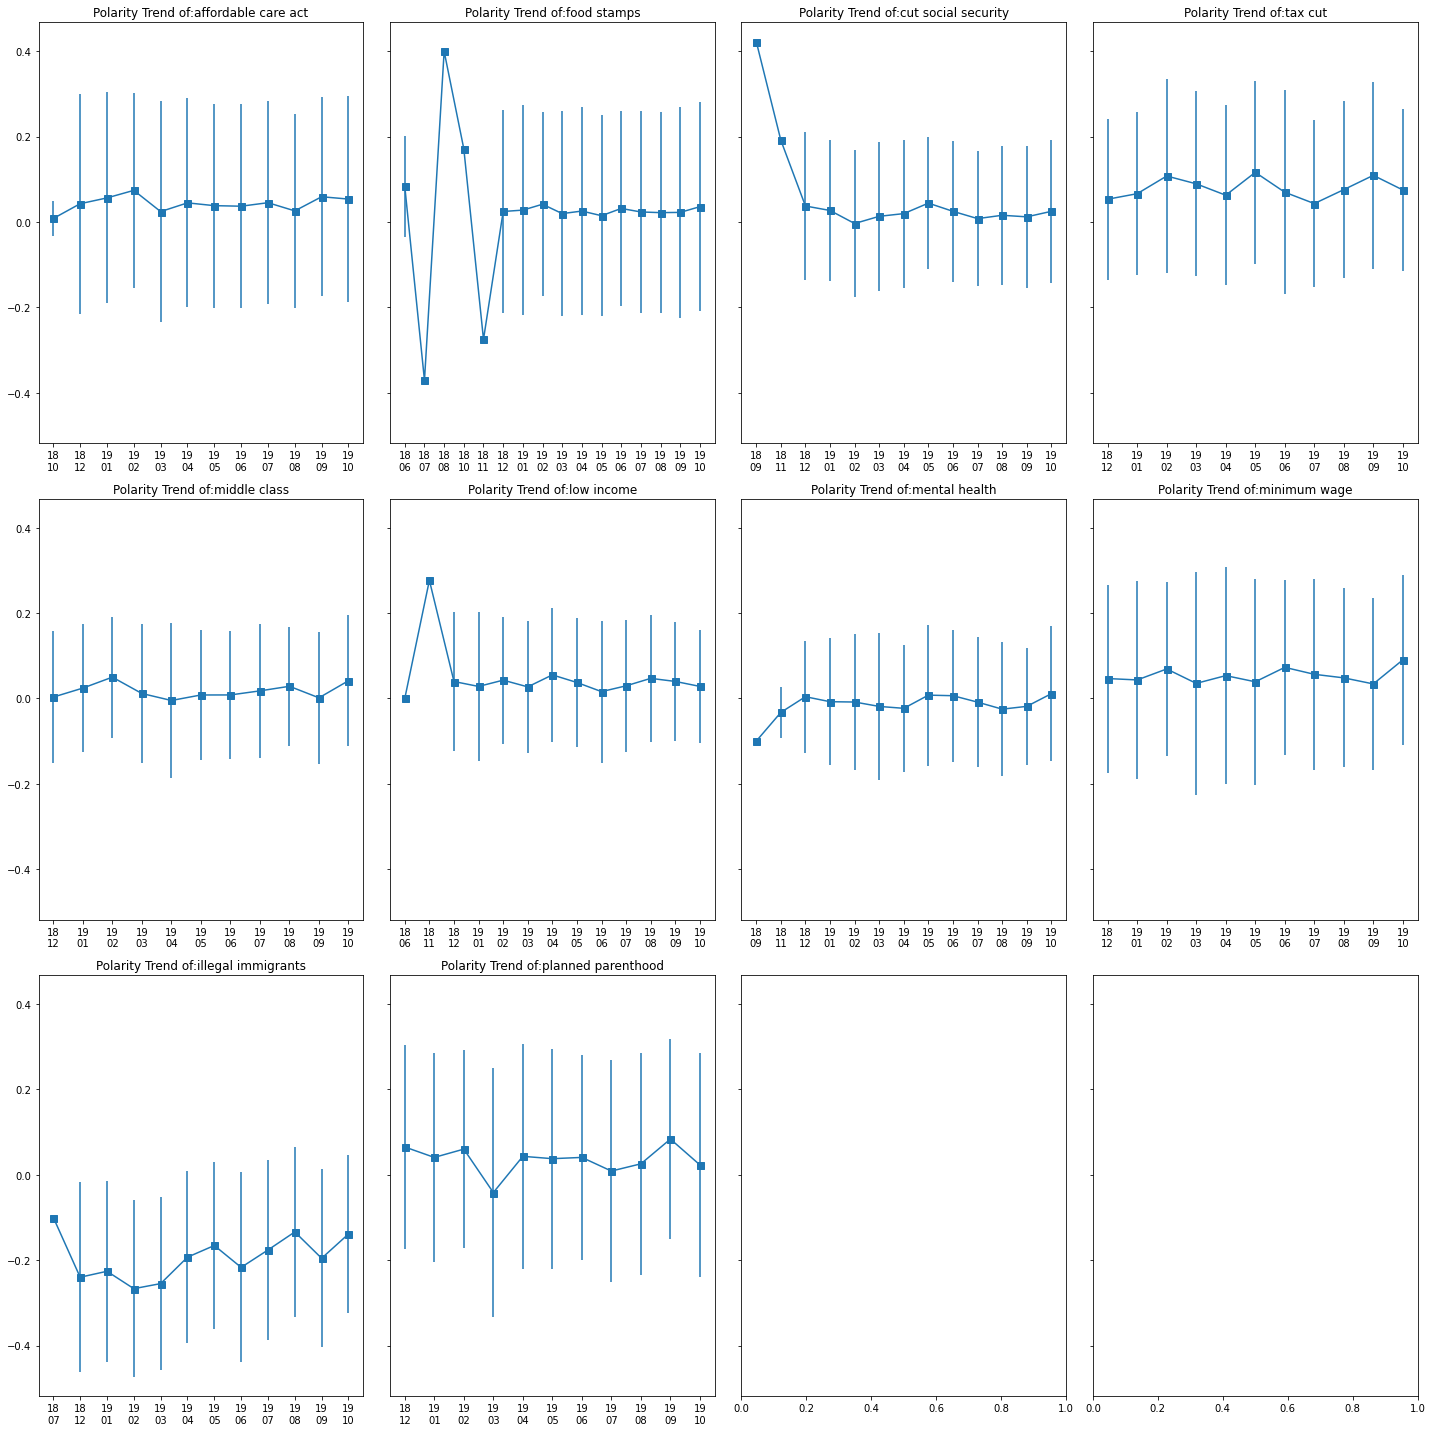

In [165]:
#plt.errorbar(x1,y1,yerr=se1,marker='s',mfc='red',mec='blue',ms=3,mew=5)
figure,axes=plt.subplots(3,4,tight_layout=True,sharey="all",figsize=(20,20))
titles=['affordable care act','food stamps','cut social security','tax cut','middle class','low income','mental health','minimum wage','illegal immigrants','planned parenthood']
axes=axes.ravel()
for ax,title in zip(axes,titles):
    subset=table[table['term']==title]
    x_labels=subset['yr_month'].apply(lambda x:(str(x)[2:4]+'\n'+str(x)[5:7]))
    ax.errorbar(x_labels,subset['polarity_mean'],yerr=subset['polarity_st_dev'],marker='s',ms=7)
    title1='Polarity Trend of:'+title
    ax.set_title(title1)
plt.show()

Time Series plots of Subjectivity Trend with Errbar

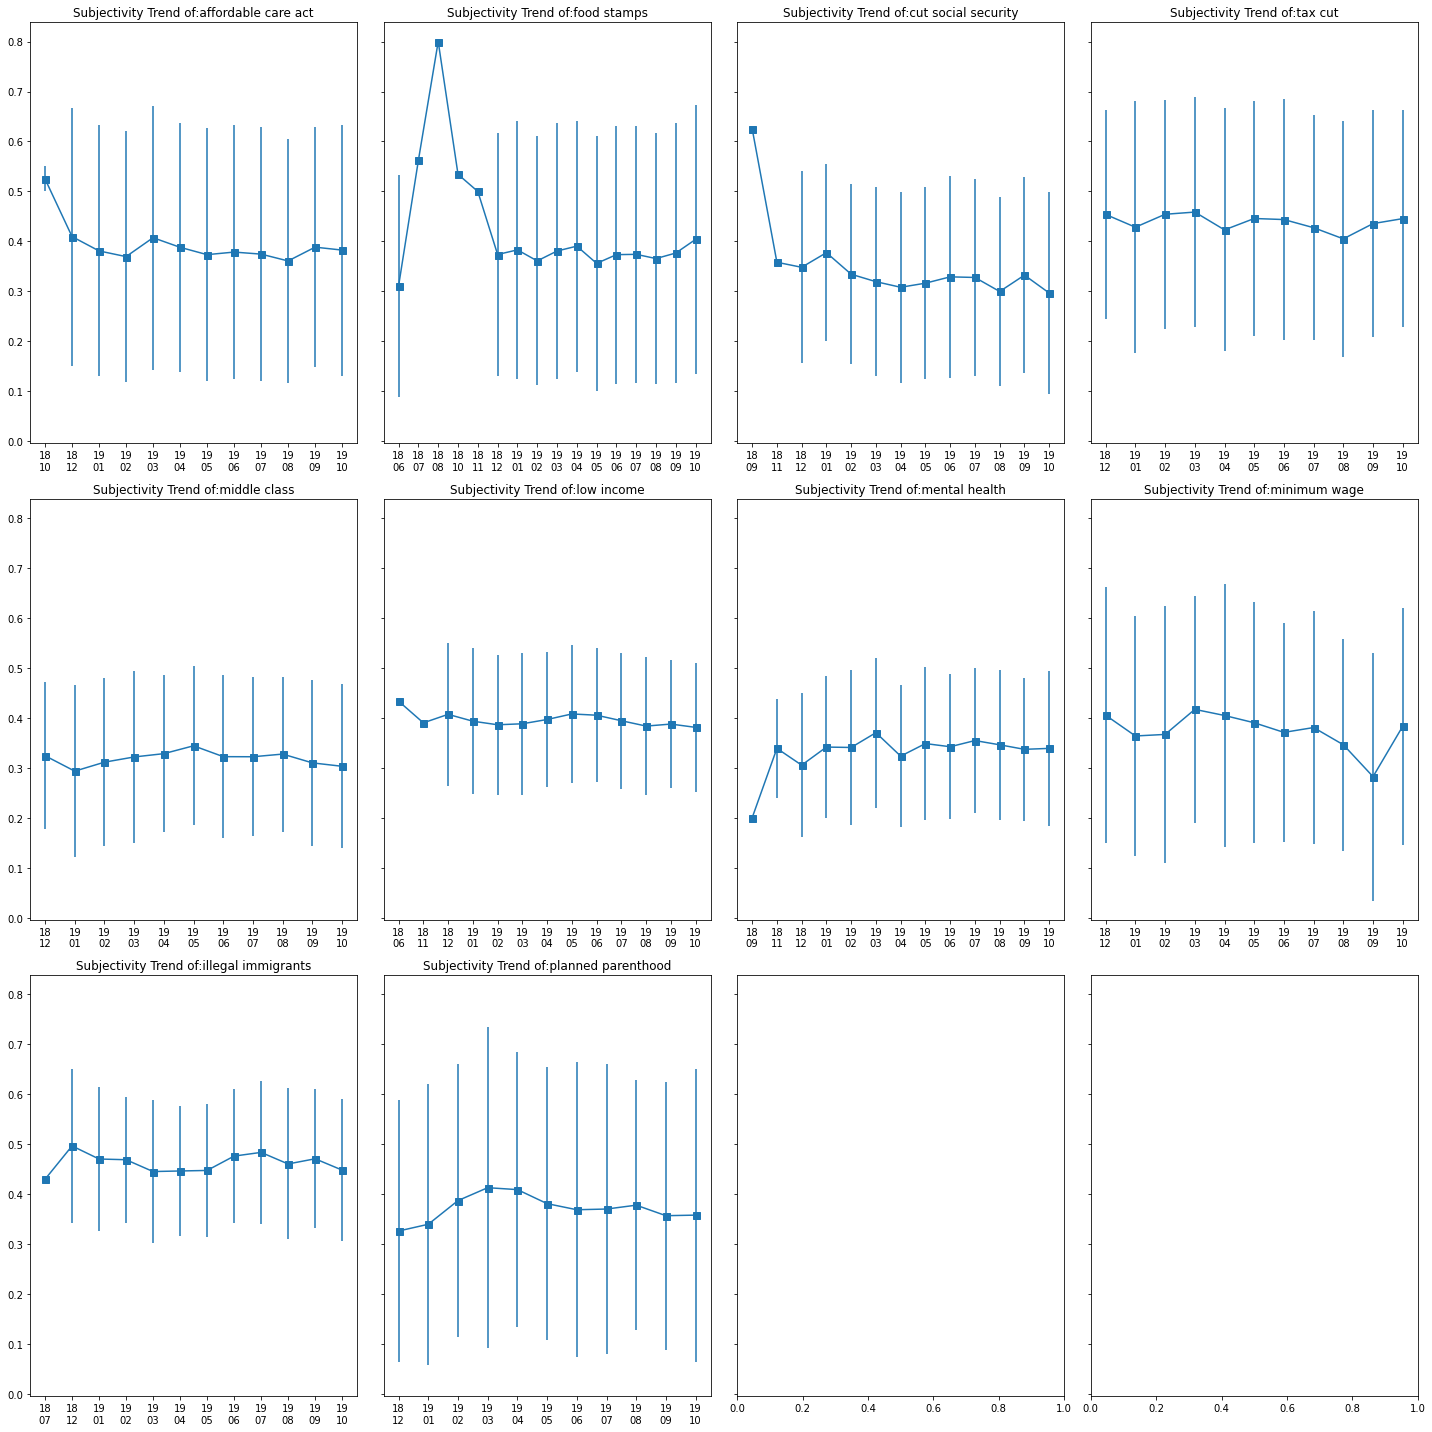

In [170]:
#plt.errorbar(x1,y1,yerr=se1,marker='s',mfc='red',mec='blue',ms=3,mew=5)
figure,axes=plt.subplots(3,4,tight_layout=True,sharey="all",figsize=(20,20))
titles=['affordable care act','food stamps','cut social security','tax cut','middle class','low income','mental health','minimum wage','illegal immigrants','planned parenthood']
axes=axes.ravel()
for ax,title in zip(axes,titles):
    subset=table[table['term']==title]
    x_labels=subset['yr_month'].apply(lambda x:(str(x)[2:4]+'\n'+str(x)[5:7]))
    ax.errorbar(x_labels,subset['subjectivity_mean'],yerr=subset['subjectivity_st_dev'],marker='s',ms=7)
    title1='Subjectivity Trend of:'+title
    ax.set_title(title1)
plt.show()

Occurrences over time

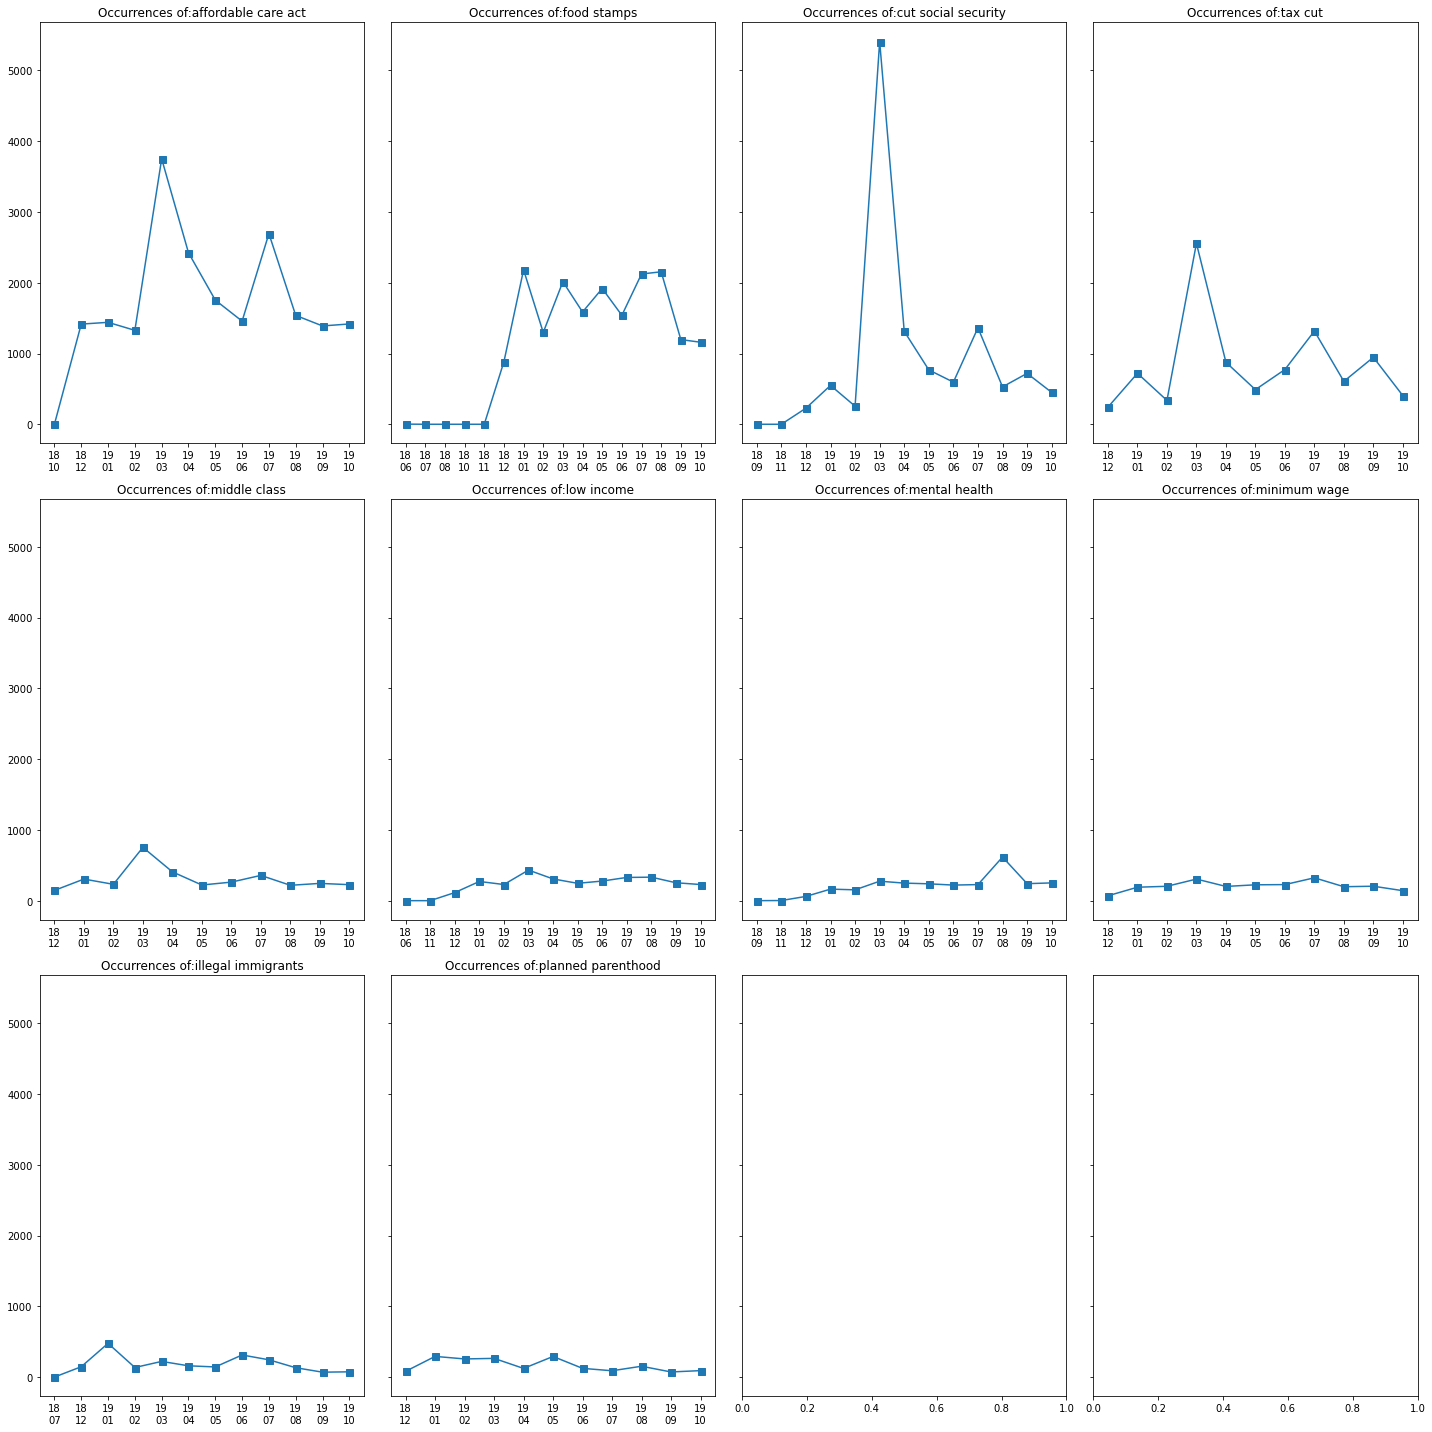

In [169]:
#plt.errorbar(x1,y1,yerr=se1,marker='s',mfc='red',mec='blue',ms=3,mew=5)
figure,axes=plt.subplots(3,4,tight_layout=True,sharey="all",figsize=(20,20))
titles=['affordable care act','food stamps','cut social security','tax cut','middle class','low income','mental health','minimum wage','illegal immigrants','planned parenthood']
axes=axes.ravel()
for ax,title in zip(axes,titles):
    subset=table[table['term']==title]
    x_labels=subset['yr_month'].apply(lambda x:(str(x)[2:4]+'\n'+str(x)[5:7]))
    ax.plot(x_labels,subset['num_of_occurrences'],marker='s',ms=7)
    title1='Occurrences of:'+title
    ax.set_title(title1)
plt.show()

In [ ]:
plt.hist(subset['polarity'],bins=7,color='r',alpha=0.5)
plt.axvline(subset['polarity'].mean(),linestyle='dashed',color='r')
plt.legend(labels=['mean','all'])



In [36]:
df['yr_month'] = df['time'].apply(lambda x:x[:7])

['2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10']


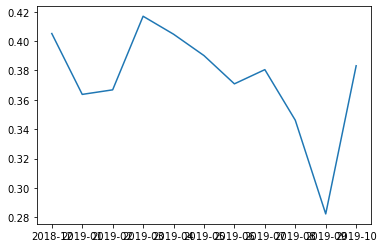

In [27]:
df1=df[df['minimum wage']==1]
x1=list(df1.groupby(['yr_month']).groups.keys())
print(x1)
y1=[]
for xx1 in x1:
    subset=df1[df1['yr_month']==xx1]
    y1.append((subset['subjectivity']).mean())
plt.plot(x1,y1)


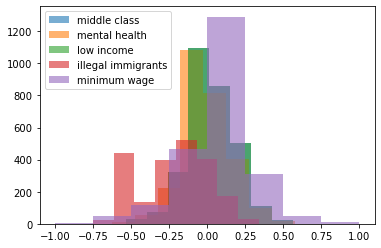

In [20]:
import matplotlib.pyplot as plt
#plt.hist(df['subjectivity'],bins=3)
subset=df[df['low income']==1]
plt.hist(subset['polarity'],bins=8,alpha=0.6)
subset=df[df['mental health']==1]
plt.hist(subset['polarity'],bins=8,alpha=0.6)
subset=df[df['low income']==1]
plt.hist(subset['polarity'],bins=8,alpha=0.6)
subset=df[df['illegal immigrants']==1]
plt.hist(subset['polarity'],bins=8,alpha=0.6)
subset=df[df['minimum wage']==1]
plt.hist(subset['polarity'],bins=8,alpha=0.6)
plt.legend(labels=['middle class','mental health','low income','illegal immigrants','minimum wage'])


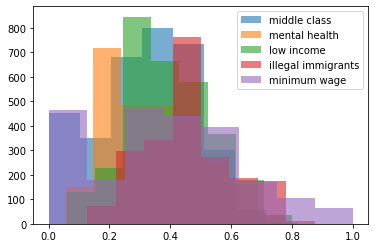

In [37]:
import matplotlib.pyplot as plt
#plt.hist(df['subjectivity'],bins=3)
subset=df[df['middle class']==1]
plt.hist(subset['subjectivity'],bins=8,alpha=0.6)
subset=df[df['mental health']==1]
plt.hist(subset['subjectivity'],bins=8,alpha=0.6)
subset=df[df['low income']==1]
plt.hist(subset['subjectivity'],bins=8,alpha=0.6)
subset=df[df['illegal immigrants']==1]
plt.hist(subset['subjectivity'],bins=8,alpha=0.6)
subset=df[df['minimum wage']==1]
plt.hist(subset['subjectivity'],bins=8,alpha=0.6)
plt.legend(labels=['middle class','mental health','low income','illegal immigrants','minimum wage'])

In [2]:
subset=df[df['mental health']==1]
plt.hist(subset['subjectivity'],bins=7,color='y',alpha=0.5)
plt.axvline(subset['subjectivity'].mean(),linestyle='dashed',color='y')
plt.legend(labels=['mean','mental health'])
min_ylim,max_ylim=plt.ylim()
plt.text(subset['subjectivity'].mean()*1.1,max_ylim*0.7,'Mean:{:.5f}'.format(subset['subjectivity'].mean()))

NameError: name 'df' is not defined

Text(0.3784299765719881, 585.795, 'Mean:-0.01086')

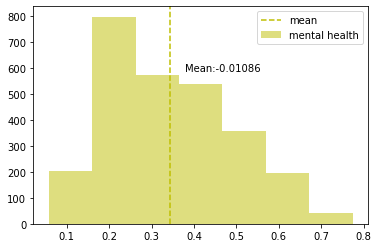

In [218]:
subset=df[df['mental health']==1]
plt.hist(subset['subjectivity'],bins=7,color='y',alpha=0.5)
plt.axvline(subset['subjectivity'].mean(),linestyle='dashed',color='y')
plt.legend(labels=['mean','mental health'])
min_ylim,max_ylim=plt.ylim()
plt.text(subset['subjectivity'].mean()*1.1,max_ylim*0.7,'Mean:{:.5f}'.format(subset['polarity'].mean()))




(array([  15.,  152.,  354., 1396., 1562., 4937., 2453.,  994.,  278.,
          46.]),
 array([-0.65555556, -0.53202381, -0.40849206, -0.28496032, -0.16142857,
        -0.03789683,  0.08563492,  0.20916667,  0.33269841,  0.45623016,
         0.5797619 ]),
 <a list of 10 Patch objects>)

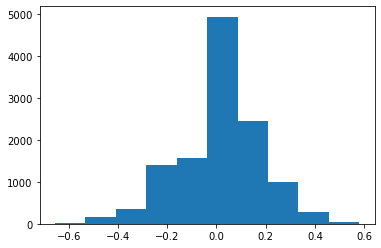

In [155]:
subset=df[df['cut social security']==1]
plt.hist(subset['polarity'],bins=10)

In [ ]:
subset=df[df['cut social security']==1]
print(subset.head(1))
plt.hist(subset,label='pol')

In [22]:
df.to_csv('df_labels_scores.csv')

In [129]:
df1 = pd.read_csv('./df_labels_scores.csv',header = 0, keep_default_na=False,dtype={'tweet_id':str})

3382

In [ ]:
df_temp=df[df['middle class'].apply(lambda x:x==1)]
len(df_temp)

In [132]:
for i in range(16):
    df_temp1=df_temp[df[bigrams_ls[i]].apply(lambda x:x==1)]
    print(len(df_temp1))
df_temp1=df_temp[df['healthcare'].apply(lambda x:x==1)]

<ipython-input-132-7e03087d1343>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_temp1=df_temp[df[bigrams_ls[i]].apply(lambda x:x==1)]
<ipython-input-132-7e03087d1343>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_temp1=df_temp[df['healthcare'].apply(lambda x:x==1)]


862
11
458
385
125
157
100
47
108
75
8
31
43
18
144
28


In [54]:
#term2 = 'trump budget'
#pattern = rf'(^|[^a-zA-Z]){term2}([^a-zA-Z]|$)' #rf is for using a variable inside
#df_temp2 = df[df['text_remove_stopwords'].apply(lambda x: re.search(pattern,x)!=None)]
#print('# of tweets:',len(df_temp2))


In [55]:
#df_temp12 =df_temp1.append(df_temp2)
#print('# of duplicated tweets:',df_temp12.duplicated(subset = ['tweet_id'], keep=False).sum())

# of duplicated tweets: 0


In [136]:
num = 30
temp = df_temp1.sample(n=num)
#for i in range(0,num):
    #print(temp['unprocessed_text'].iloc[i],'\n\n')
    #print(temp['text_remove_stopwords'].iloc[i],'\n\n')
    #print('---------------------------------------------------------------------------------')

In [137]:
#temp.to_csv('ss_pec_sample.csv')
#temp.to_csv('mh_e_sample.csv')
temp.to_csv('mc_h_sample.csv')

